# Simple Baseline Algorithm

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.kernel_approximation import RBFSampler

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", palette="muted", color_codes=True)

np.random.seed(seed=123456) 

In [11]:
def map_loc(loc):
    # map the person location to location 3x3 matrix
    pos = [[loc+i*8-1, loc+i*8, loc+i*8+1] for i in [-1,0,1]]
    return pos[0]+pos[1]+pos[2]

def simulate_data_stream(person_infor):
    """simulate data with two person occupancy
    """
    data = pd.DataFrame(np.random.normal(20, .5, (400, 64)), columns=[''.join(['L_', str(i)]) for i in range(64)])
    for key in list(person_infor.keys()):
        person = person_infor[key]
        for loc in map_loc(person['loc']):
            if loc != person['loc']:
                data.iloc[person['time'][0]:person['time'][1], loc] += person['temp'] * person['corr']
            else:
                data.iloc[person['time'][0]:person['time'][1], loc] += person['temp']
    return data

def figure_plt(data, time, print_mat=False):
    mat = data.iloc[time,:].values.reshape(8,8)
    plt.figure()
    ax = plt.gca()
    plt.imshow(mat, cmap='RdBu')
    plt.colorbar(extend='both')
    ax.grid(which='minor', axis='both', color='k', linewidth=2)
    plt.clim(17, 29)
    if print_mat:
        print(mat)

def time_series_plt(data, time):
    plt.figure(figsize=(8,4))
    plt.plot(range(data.shape[0]), data.iloc[:,18])
    plt.ylabel('Temperature')
    plt.xlabel('Time')

In [12]:
class EXPoSE(object):
    """ Implementation of The EXPoSE (EXPected Similarity Estimation) algorithm 
    proposed by M. Schneider, W. Ertel and F. Ramos, "Expected Similarity 
    Estimation for Lage-Scale Batch and Streaming Anomaly Detection".
    """
    def __init__(self, decay_rate=.01, time_step=0,
                 headers=["time", "value", "anomaly_score"]):
        self.decay_rate = decay_rate
        self.time_step = time_step
        self.headers = headers
        self.kernel = None
        self.historical_model = []
    
    def set_kernel(self, gamma=.5, n_components=500, random_state=10):
        #n_components=20000
        """ Setup RBF sampler for the detector"""
        self.kernel = RBFSampler(gamma=gamma, n_components=n_components, random_state=random_state)
    
#     def run_offline(self, data):
#         """ Run offline with batch data
#         """
#         rows = []
#         for i, row in data.iterrows():
#             input_data = row.to_dict()
#             detector_values = self.analyze(input_data)
#             output_row = list(row) + list(detector_values)
#             rows.append(output_row)
#         results = pd.DataFrame(rows, columns=self.headers)
#         return results
    
    def initialize(self, data):
        """ setup reference data withouth occupancy
        """
        return self.analyze(data)
    
    def analyze(self, input_data):
        """ Returns anomalyScore list """
        # approximate feature map of a RBF kernel by using Random Kitchen 
        # Sinks approximation
        feature = self.kernel.fit_transform(np.array([[input_data]]))
        # calculate model as a weighted sum of new data point's feature
        # map and previous data points' kernel embedding
        if self.time_step == 0:
            model = feature
            self.time_step += 1
        else:
            model = ((self.decay_rate * feature) + (1 - self.decay_rate) *
                     self.historical_model)
        # Update previous expose model
        self.historical_model = model
        # Caculate similarity measure
        anomaly_score = np.asscalar(1 - np.inner(feature, model))

        return anomaly_score

In [35]:
class Detector(object):
    """ detector for streaming frame
    """
    def __init__(self, th=.8, diff=.3):
        self.th = th
        self.diff = diff
        # map to store the occupancy status
        self.map = np.zeros(64)
        # buffer to store the previous 3 scores
        self.scores = np.zeros((3,64))
        self.detector = [EXPoSE() for i in range(64)]

    def set_ref(self, ref_dat):
        for j, ref_snapshoot in enumerate(ref_dat):
            for i, x in enumerate(ref_snapshoot):
                if j == 0:
                    self.detector[i].set_kernel()
                self.scores[j, i] = np.array(self.detector[i].initialize(x))
        
    def run_online(self, input_dat):
        historical_scores = self.scores[1:, :]
        for i, x in enumerate(input_dat):
            self.scores[-1, i] = np.array(self.detector[i].analyze(x))
        self.scores[:2, :] = historical_scores
        self.find_temporal_change()
    
    def find_temporal_change(self):
        summary = np.mean(self.scores, axis=0)
        occupied_idx = np.where(self.map == 1)[0]
        idx = np.where(summary >= self.th)[0]
        for i in idx:
            self.map[i] = 1
        # check if non-occupancy
        if len(occupied_idx) == 0:
            for j in occupied_idx:
                if self.scores[-1, j] - self.scores[1, j] >= self.diff:
                    self.map[j] = 0
            

generate sample data

In [36]:
person_infor = {'person_1':{'loc':18, 'temp':5, 'corr': .8, 'time':[200, 250]},
                'person_2':{'loc':46, 'temp':4, 'corr': .8, 'time':[200, 250]}}
data = simulate_data_stream(person_infor)
# first 3 rows are considered training data
train = [data.iloc[i,:].values.tolist() for i in range(3)]

In [37]:
data.head(3)

,L_0,L_1,L_2,L_3,L_4,L_5,L_6,L_7,L_8,L_9,...,L_54,L_55,L_56,L_57,L_58,L_59,L_60,L_61,L_62,L_63
0,19.372085,19.245103,19.603039,19.592699,20.556455,20.223049,20.388944,19.790181,20.376175,20.302428,...,19.530174,19.653352,20.029602,19.970195,19.335456,19.862935,19.962422,20.125697,20.135209,19.924888
1,20.030936,20.480408,19.834483,20.441529,20.126034,20.080820,19.705797,19.815511,20.207486,20.171041,...,20.555559,19.787147,19.836377,19.928163,19.526569,20.233000,19.967460,20.060793,19.846960,20.066221
2,19.943469,20.048656,20.840355,20.163353,19.812887,20.045584,19.687495,19.671188,19.531047,20.603140,...,20.526006,21.349575,19.956864,20.057066,20.272479,20.329221,20.599574,19.234553,21.245473,19.637343


signal without occupancy

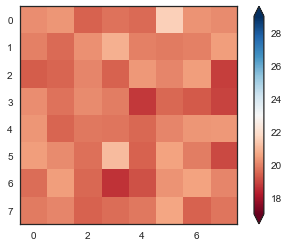

In [38]:
figure_plt(data, 10, False)

Signal with occupancy: two perons

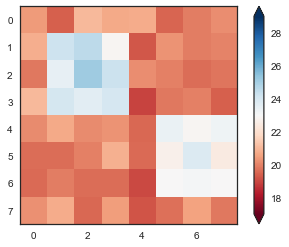

In [39]:
figure_plt(data, 200, False)

plot time series at position 18

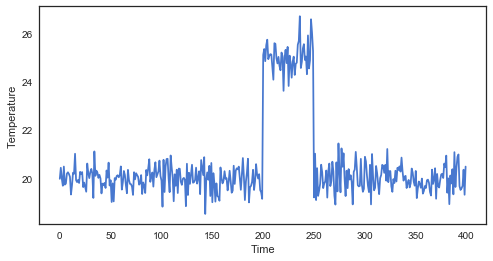

In [40]:
time_series_plt(data, 18)

In [41]:
detector = Detector()
detector.set_ref(train)

In [42]:
detector.map

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [44]:
if __name__ == '__main__':
    person_infor = {'person_1':{'loc':18, 'temp':5, 'corr': .8, 'time':[200, 250]},
                'person_2':{'loc':46, 'temp':4, 'corr': .8, 'time':[200, 250]}}
    data = simulate_data_stream(person_infor)
    # first 3 rows are considered training data
    train = [data.iloc[i,:].values.tolist() for i in range(3)]
    detector = Detector()
    detector.set_ref(train)
    for i in range(3, data.shape[0]):
        test = data.iloc[i,:].values.tolist()
        detector.run_online(test)
        idx = np.where(detector.map == 1)
        if len(idx[0]) > 0:
            print('The time point is {}'.format(i))
            print('MAP:')
            print(detector.map)
            break

The time point is 200
MAP:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
